# Numpy and Pandas Performance Comparison
[Goutham Balaraman](http://gouthamanbalaraman.com)

Pandas and Numpy are two packages that are core to a lot of data analysis. In this post I will compare the performance of numpy and pandas. 

tl;dr:
- `numpy` consumes less memory compared to `pandas`
- `numpy` generally performs better than `pandas` for 50K rows or less
- `pandas` generally performs better than `numpy` for 500K rows or more
- for 50K to 500K rows, it is a toss up between `pandas` and `numpy` depending on the kind of operation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")
%matplotlib inline
import seaborn.apionly as sns
import numpy as np
from timeit import timeit 
import sys

In [2]:
iris = sns.load_dataset('iris')

In [3]:
data = pd.concat([iris]*100000)
data_rec = data.to_records()

In [4]:
print (len(data), len(data_rec))

15000000 15000000


Here I have loaded the `iris` dataset and replicated it so as to have 15MM rows of data. The space requirement for 15MM rows of data in a `pandas dataframe` is more than twice that of a `numpy recarray`.

In [5]:
MB = 1024*1024
print("Pandas %d MB " % (sys.getsizeof(data)/MB))
print("Numpy %d MB " % (sys.getsizeof(data_rec)/MB))

Pandas 1506 MB 
Numpy 686 MB 


A snippet of the data shown below.

In [6]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [7]:
# <!-- collapse=True -->
def perf(inp, statement, grid=None):
    length = len(inp) 
    gap = int(length/5)
    #grid = np.array([int(x) for x in np.logspace(np.log10(gap), np.log10(length+1) , 5)])
    if grid is None:
        grid = np.array([10000, 100000, 1000000, 5000000, 10000000])
    num = 100
    time = []
    data = {'pd': pd, 'np': np}
    for i in grid:
        if isinstance(inp, pd.DataFrame):
            sel = inp.iloc[:i]
            data['data'] = sel
        else:
            sel = inp[:i]
            data['data_rec'] = sel
        t = timeit(stmt=statement, globals=data, number=num)
        time.append(t/num)
    return grid, np.array(time)

def bench(pd_inp, pd_stmt, np_inp, np_stmt, title="", grid=None):
    g,v1 = perf(pd_inp, pd_stmt, grid)
    g,v2 = perf(np_inp, np_stmt, grid)
    fig, ax = plt.subplots()
    ax.loglog()
    ax.plot(g, v1, label="pandas",marker="o", lw=2)
    ax.plot(g, v2, label="numpy", marker="v", lw=2)
    ax.set_xticks(g)
    plt.legend(loc=2)
    plt.xlabel("Number of Records")
    plt.ylabel("Time (s)")
    plt.grid(True)
    plt.xlim(min(g)/2,max(g)*2)
    plt.title(title)

In this post, performance metrics for a few different categories are compared between `numpy` and `pandas`:
- operations on a column of data, such as mean or applying a vectorised function
- operations on a filtered column of data
- vector operations on a column or filtered column



## Operations on a Column

Here some performance metrics with operations on one column of data. The operations involved in here include fetching a view, and a reduction operation such as `mean`, vectorised `log` or a string based `unique` operation. All these are `O(n)` calculations. The mean calculation is orders of magnitude faster in `numpy` compared to `pandas` for array sizes of 100K or less. For sizes larger than 100K `pandas` maintains a lead over `numpy`.

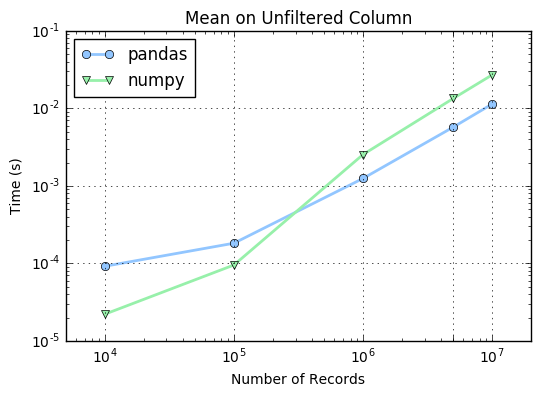

In [8]:
bench(data, "data.loc[:, 'sepal_length'].mean()", 
      data_rec, "np.mean(data_rec.sepal_length)",
     title="Mean on Unfiltered Column")

Below, the vectorized `log` operation is faster in `numpy` for sizes less than 100K but pandas costs about the same for sizes larger than 100K.

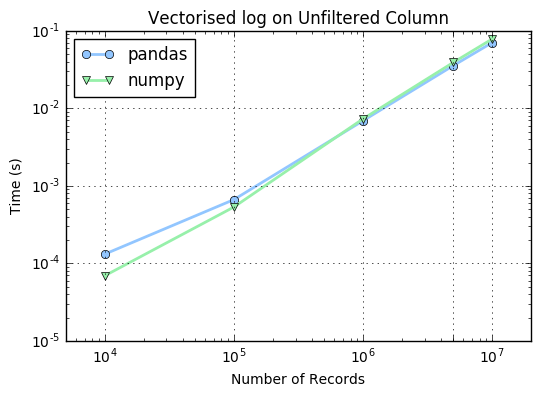

In [9]:
bench(data, "np.log(data.loc[:, 'sepal_length'])",
      data_rec, "np.log(data_rec.sepal_length)",
     title="Vectorised log on Unfiltered Column")

The one differentiating aspect about the test below is that the column `species` is of string type. The operation demonstrated is a `unique` calculation. We observe that the `unique` calculation is roughly an order of magnitude faster in pandas for sizes larger than 1K rows. 

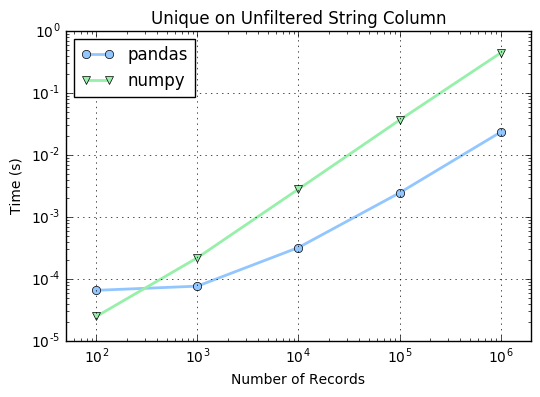

In [10]:
bench(data, "data.loc[:,'species'].unique()",
      data_rec, "np.unique(data_rec.species)", 
      grid=np.array([100, 1000, 10000, 100000, 1000000]),
     title="Unique on Unfiltered String Column")

## Operations on a Filtered Column

Below we perform the same tests as above, except that the column is not a full view, but is instead a filtered view. The filters are simple filters with an arithmetic bool comparison for the first two and a string comparison for the third below. 

Below, `mean` is calculated for a filtered column `sepal_length`. Here performance of `pandas` is better for row sizes larger than 10K. In the `mean` on unfiltered column shown above, `pandas` performed better for 1MM or more. Just having selection operations has shifted performance chart in favor of `pandas` for even smaller number of records.

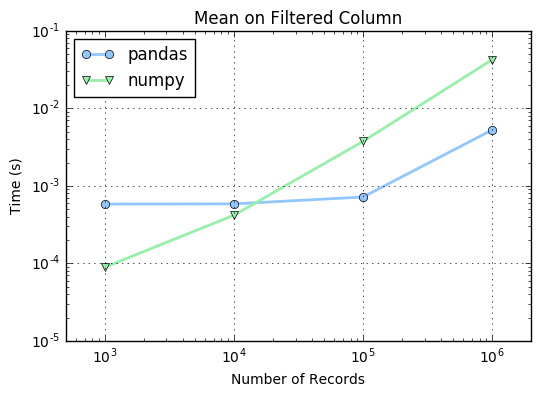

In [11]:
bench(data, "data.loc[(data.sepal_width>3) & \
             (data.petal_length<1.5), 'sepal_length'].mean()",
      data_rec, "np.mean(data_rec[(data_rec.sepal_width>3) & \
                 (data_rec.petal_length<1.5)].sepal_length)",
      grid=np.array([1000, 10000, 100000, 1000000]),
     title="Mean on Filtered Column")

For vectorised `log` operation on a unfiltered column shown above, `numpy` performed better than `pandas` for number of records less than 100K while the performance was comparable for the two for sizes larger than 100K. But the moment you introduce a filter on a column, `pandas` starts to show an edge over `numpy` for number of records larger than 10K.

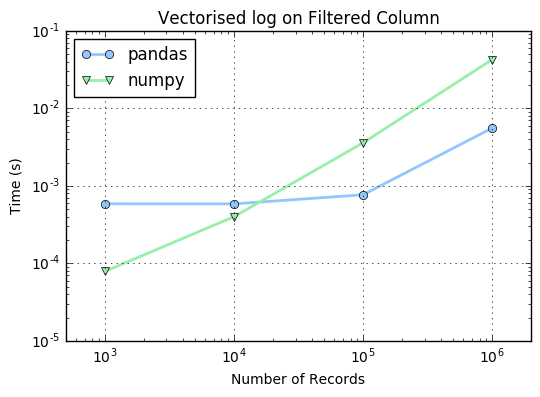

In [12]:
bench(data, "np.log(data.loc[(data.sepal_width>3) & \
            (data.petal_length<1.5), 'sepal_length'])",
      data_rec, "np.log(data_rec[(data_rec.sepal_width>3) & \
                 (data_rec.petal_length<1.5)].sepal_length)",
      grid=np.array([1000, 10000, 100000, 1000000]),
     title="Vectorised log on Filtered Column")

Here is another example of a `mean` reduction on a column but with a string filter. We see a similar behavior where `numpy` performs significantly better at small sizes and `pandas` takes a gentle lead for larger number of records.

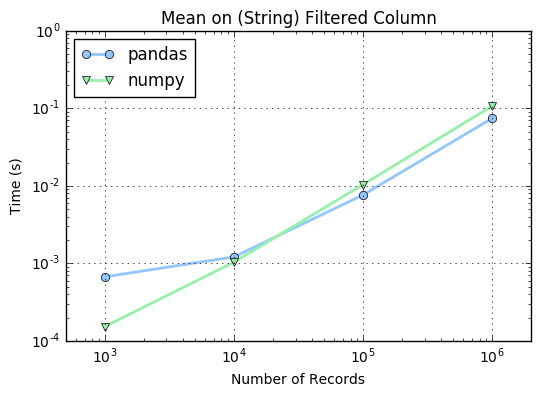

In [13]:
bench(data, "data[data.species=='setosa'].sepal_length.mean()",
      data_rec, "np.mean(data_rec[data_rec.species=='setosa'].sepal_length)",
      grid=np.array([1000, 10000, 100000, 1000000]),
     title="Mean on (String) Filtered Column")

## Vectorized Operation on a Column

In this last section, we do vectorised arithmetic using multiple columns. This involves creating a view and vectorised math on these views. Even when there is no filter, `pandas` has a slight edge over `numpy` for large number of records. For smaller than 100K records, `numpy` performs significantly better.

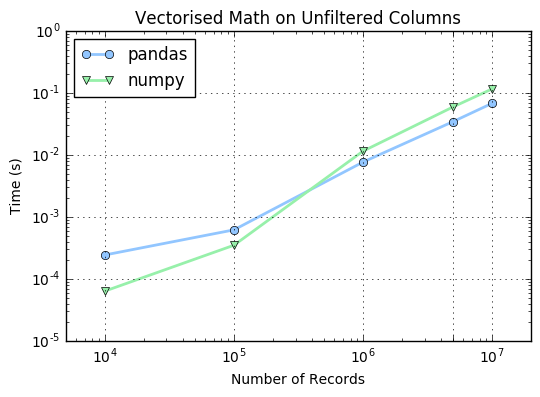

In [14]:
bench(data, "data.petal_length * data.sepal_length + \
      data.petal_width * data.sepal_width",
      data_rec, "data_rec.petal_length*data_rec.sepal_length + \
      data_rec.petal_width * data_rec.sepal_width",
     title="Vectorised Math on Unfiltered Columns")

In the following figure, the filter involves vectorised arithmetic operation, and `mean` reduction is computed on the filtered column. The presence of a filter makes `pandas` significantly faster for sizes larger than 100K, while `numpy` maitains a lead for smaller than 10K number of records. 

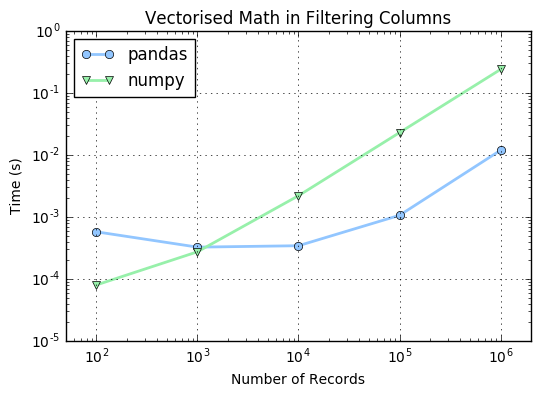

In [16]:
bench(data, "data.loc[data.sepal_width * data.petal_length > \
             data.sepal_length, 'sepal_length'].mean()",
      data_rec, "np.mean(data_rec[data_rec.sepal_width * data_rec.petal_length \
                 > data_rec.sepal_length].sepal_length)",
     title="Vectorised Math in Filtering Columns",
     grid=np.array([100, 1000, 10000, 100000, 1000000]))

## Conclusion

`Pandas` is often used in an interactive environment such as through Jupyter notebooks. In such a case, any performance loss from `pandas` will be in significant. But if you have smaller `pandas` dataframes (<50K number of records) in a production environment, then it is worth considering `numpy` recarrays. 
- `numpy` consumes (roughtly 1/3) less memory compared to `pandas`
- `numpy` generally performs better than `pandas` for 50K rows or less
- `pandas` generally performs better than `numpy` for 500K rows or more
- for 50K to 500K rows, it is a toss up between `pandas` and `numpy` depending on the kind of operation